## Assignment 3 - Deffuant model

**Course:** Simulation Modeling of Financial and Economic Systems <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 




## 0. Prerequisites

In [1]:
import mesa
import random
import numpy as np

from mesa import Agent, Model
from mesa.time import SimultaneousActivation

## 1. Define a model

In [2]:
class DeffuantAgent(Agent):
    
    def __init__(self, unique_id, opinion, uncertainty, intensity_interaction, model):
        super().__init__(unique_id, model)
        self.opinion = opinion
        self.uncertainty = uncertainty
        self.intensity_interaction = intensity_interaction
        self.model = model
        self.n_agents = self.model.n_agents
        self._interacted = [False] * self.n_agents
        self._interacted[self.unique_id] = True
        self._ids = [i for i in range(self.n_agents)]
        self._opinion_delta = 0
        self._uncertainty_delta = 0
    
    def _interact(self, agent):
        overlap = min(self.opinion + self.uncertainty, agent.opinion + agent.uncertainty) - max(self.opinion - self.uncertainty, agent.opinion - agent.uncertainty)
        relative_agreement = max(0, overlap / self.uncertainty - 1)
        multiplier = 1 if self.model.mode == "pairwise" else 1 / (self.n_agents - 1)
        self._opinion_delta += multiplier * self.intensity_interaction * relative_agreement * (agent.opinion - self.opinion)
        self._uncertainty_delta += multiplier * self.intensity_interaction * relative_agreement * (agent.uncertainty - self.uncertainty)
        self._interacted[agent.unique_id] = True
        agent._interacted[self.unique_id] = True
    
    def _pair(self, population):
        pairs = []
        shuffled = random.sample(self._ids, self.n_agents)
        for agent_idx in shuffled:
            if not population[agent_idx]._check_interaction(idx=self.unique_id):
                pairs.append(population[agent_idx])
                if self.model.mode == "pairwise":
                    break
        return pairs
    
    def step(self):
        if self._check_interaction():
            return
        population = self.model.schedule.agents
        agents = self._pair(population)
        for agent in agents:
            self._interact(agent)
            agent._interact(self)
            
    def _check_interaction(self, idx=None):
        if idx is not None:
            return self._interacted[idx]
        if self.model.mode == "pairwise":
            return self._interacted.count(True) == 2
        return self._interacted.count(True) == len(self._interacted)

    def advance(self):
        self.opinion = min(1, max(-1, self.opinion + self._opinion_delta))
        self.uncertainty = max(1e-3, self.uncertainty + self._uncertainty_delta)
        self._interacted = [False] * self.n_agents
        self._interacted[self.unique_id] = True
        self._opinion_delta = 0
        self._uncertainty_delta = 0

In [3]:
class DeffuantModel(Model):
    
    def __init__(self, 
                 n_agents=1000,
                 percentage_extremists=0.07,
                 uncertainty_moderate=0.5,
                 uncertainty_extremists=0.1,
                 propotion_positive_negative_extremists=1,
                 intensity_interaction=0.5,
                 mode="pairwise"
                ):
        assert n_agents % 2 == 0, "Number of agents must be even!"
        assert mode == "pairwise" or mode == "all-with-all", 'Mode is either "pairwise" or "all-with-all"'
        self.n_agents = n_agents
        self.percentage_extremists = percentage_extremists
        self.uncertainty_moderate = uncertainty_moderate
        self.uncertainty_extremists = uncertainty_extremists
        self.propotion_positive_negative_extremists = propotion_positive_negative_extremists
        self.intensity_interaction = intensity_interaction  
        self.mode = mode
        self.schedule = SimultaneousActivation(self)
        self.history = []
        
        self._derive_parameters()
        self._create_agents()
    
    def get_state(self):
        return np.array([a.opinion for a in self.schedule.agents])
    
    def step(self):
        state = self.get_state()
        self.history.append(state)
        self.schedule.step()
        
    def _derive_parameters(self):
        self.n_extremists = int(self.n_agents * self.percentage_extremists)
        propotion = self.propotion_positive_negative_extremists
        percentage_positive_extremists = propotion / (1 + propotion)
        self.n_moderate = self.n_agents - self.n_extremists        
        self.n_positive_extremists = int(self.n_extremists * percentage_positive_extremists)
        self.n_negative_extremists = self.n_extremists - self.n_positive_extremists
        
    def _create_agents(self):
        agents = []
        opinions = np.random.uniform(-1, 1, self.n_agents)
        opinions.sort()
        
        positive_opinions = opinions[-self.n_positive_extremists:]
        negative_opinions = opinions[:self.n_negative_extremists]
        moderate_opinions = opinions[self.n_negative_extremists:-self.n_positive_extremists]
        
        for opinion in positive_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_extremists, self.intensity_interaction, self)
            agents.append(a)
        
        for opinion in negative_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_extremists, self.intensity_interaction, self)
            agents.append(a)
        
        for opinion in moderate_opinions:
            a = DeffuantAgent(len(agents), opinion, self.uncertainty_moderate, self.intensity_interaction, self)
            agents.append(a)

        for agent in agents:
            self.schedule.add(agent)
            

In [74]:
def run_simulation(iterations=100, mode="pairwise", verbose=False):
    model = DeffuantModel(mode=mode)
    iterator = tqdm(range(iterations)) if not verbose else range(iterations)
    for _ in iterator:
        model.step()
    return model

In [75]:
def plot_chart(model):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Opinion Segmentation ({model.mode})")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Opinion")
    history = model.history 
    ax1.plot(np.arange(1, len(history) + 1), np.array(history), '-')
    plt.xlim([1, len(history)])
    plt.ylim([-1, 1])
    plt.show() 

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


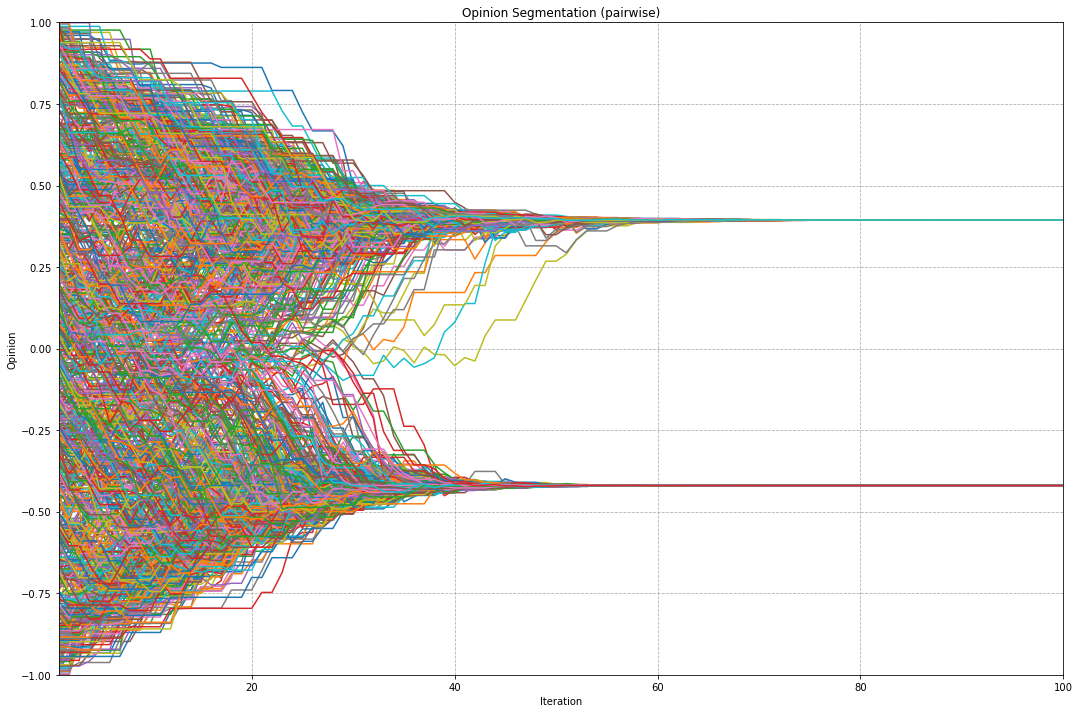

In [76]:
model = run_simulation(mode="pairwise")
plot_chart(model)

100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


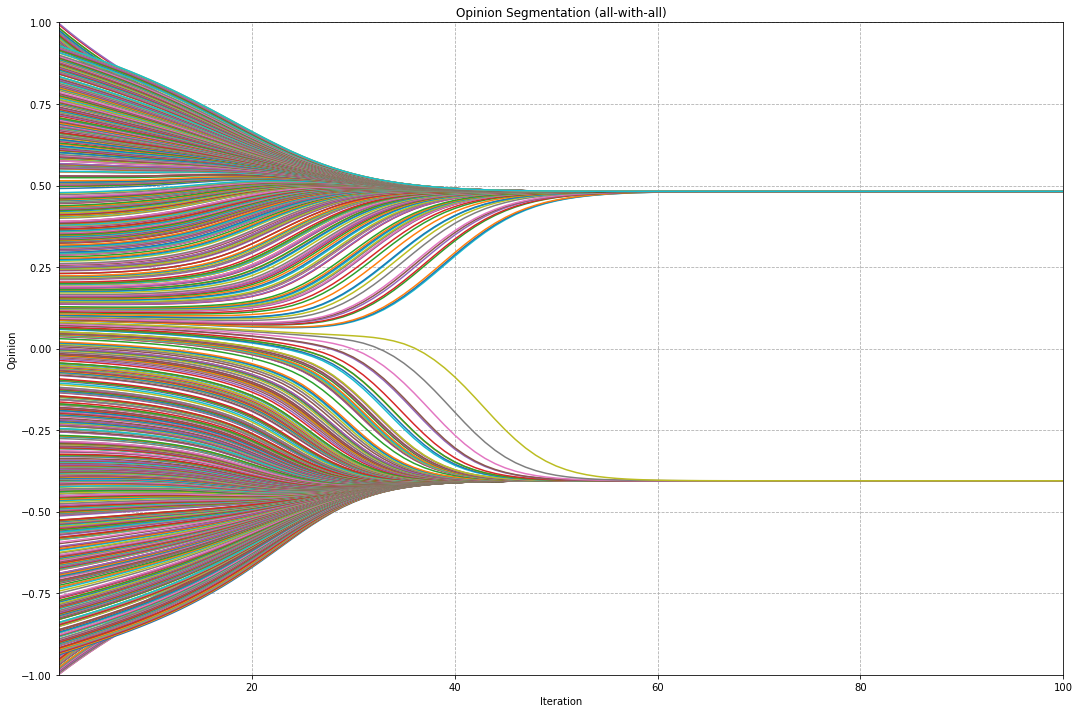

In [77]:
model = run_simulation(mode="all-with-all")
plot_chart(model)